### Visualize Heat Map Class Activations

```
Use the XCeption Model model to display a heat map to highlight what parts of an image are more influential in object recognition. 

The VGG16 model has been trained with many different images (animals, appliances, people, other) so here the model gets a variety of images to explore how well the "Class HeatMap " works with those images.

The images are

    Elephant (done, nice)
    Cat (done, nice)
    Dog (done, nice)
    Baby (done, not that good)
    Eagle (done, nice)
    Bicycle (done, nice) 

```


In [1]:
# get the libraries ready
import os
import shutil, pathlib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
# import keras
from keras.utils import load_img, img_to_array
from keras.utils import array_to_img
from keras.utils import image_dataset_from_directory

from keras import layers

import numpy as np
import random
import cv2

from IPython.display import Image

2025-02-22 13:56:48.153861: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740250608.167594   18990 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740250608.171506   18990 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-22 13:56:48.188973: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Get xCeption as a pretrained model
 
# model = keras.applications.xception.Xception( weights = "imagenet" )

model = keras.applications.xception.Xception 

In [ ]:
# print the names of all the layers in the model of type Conv2D and  SeparableConvolution2D

#for layer in model.layers :
#    if isinstance (layer, (keras.layers.Conv2D, keras.layers.SeparableConvolution2D)) :
#        print( layer.name)

In [ ]:

# https://img-datasets.s3.amazonaws.com/elephant.jpg


# XCeption was traine with images of size (299,299)... 
img_size = (299, 299)

img_path = "/drv3/hm3/Data/ImgData/Oxford_iiit_pets/cat_img_from_amazon_s3.jpg"
# img_path = "/drv3/hm3/Data/ImgData/Oxford_iiit_pets/elephant_img_from_amazon_s3.jpg"
#img_path = "/drv3/hm3/Data/ImgData/cats/cat.13.jpg"
#img_path = "/drv3/hm3/Data/ImgData/dogs/dmeet55.jpg"
#img_path = "/drv3/hm3/Data/ImgData/eigenFaces/558Faces/1_0_0_20170109191725028.jpg.chip.jpg"
img_path = "/drv3/hm3/Data/ImgData/OtherImgs/Eagle.png"
# img_path = "/drv3/hm3/Data/ImgData/OtherImgs/Bicycle.png"
img_path = "/drv3/hm3/Data/ImgData/Oxford_iiit_pets/CeciliaMaya.png"
img_path = "/drv3/hm3/Data/ImgData/Helicoptero.JPG"



# get sample img as a tensor
def get_img_array( img_path, target_size) :
    img = keras.utils.load_img( img_path, target_size=target_size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)

    # this line is crucial: It is different from the Filter app 
    array = keras.applications.xception.preprocess_input( array) 
    return array

img_array = get_img_array(img_path, target_size= img_size)


display(Image(img_path))

FileNotFoundError: [Errno 2] No such file or directory: '/drv3/hm3/Data/ImgData/Helicoptero.png'

In [24]:
model_builder = keras.applications.xception.Xception
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = 'block14_sepconv2_act'
classifier_layer_names = [
  'avg_pool',
  'predictions',
]



In [25]:
def get_img_array_lofas (img_path, size):
  # `img` is a PIL image of size 224x224￼
  img = keras.preprocessing.image.load_img(img_path, target_size=size)
  # `array` is a float32 Numpy array of shape (224, 224, 3)
  array = keras.preprocessing.image.img_to_array(img)
  # We add a dimension to transform our array into a "batch"
  # of size (1, 224, 224, 3)
  array = np.expand_dims(array, axis=0)
  return array

def get_img_array (img_path, size):
  # `img` is a PIL image of size 224x224￼
  img = load_img(img_path, target_size=size)
  # `array` is a float32 Numpy array of shape (224, 224, 3)
  array = img_to_array(img)
  # We add a dimension to transform our array into a "batch"
  # of size (1, 224, 224, 3)
  array = np.expand_dims(array, axis=0)
  return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names):
  # Create model for mapping input img to last conv layer activations
  last_conv_layer = model.get_layer(last_conv_layer_name)
  last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

  # Create model for mapping last conv activations to final class predictions
  classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
  x = classifier_input
  for layer_name in classifier_layer_names:
    x = model.get_layer(layer_name)(x)
  classifier_model = keras.Model(classifier_input, x)

  # Now compute the gradient of the top predicted class for input img
  # wrt to the activations of the last conv layer
  with tf.GradientTape() as tape:
    # Compute activations of the last conv layer and make the tape watch it
    last_conv_layer_output = last_conv_layer_model(img_array)
    tape.watch(last_conv_layer_output)
    # Compute class predictions
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]

  # This is the gradient of the top predicted class with regard to
  # the output feature map of the last conv layer
  grads = tape.gradient(top_class_channel, last_conv_layer_output)

  # This is a vector where each entry is the mean intensity of the gradient
  # over a specific feature map channel
  pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

  # multiply each channel in the feature map array￼
  # by "how important this channel is" wrt the top predicted class
  last_conv_layer_output = last_conv_layer_output.numpy()[0]
  pooled_grads = pooled_grads.numpy()
  for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]

  # The channel-wise mean of the resulting feature map
  # is the heatmap of the class activation
  heatmap = np.mean(last_conv_layer_output, axis=-1)

  # For visualization purpose, normalize the heatmap between 0 & 1
  heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
  return heatmap

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted: [('n02113624', 'toy_poodle', 0.45418912), ('n02113712', 'miniature_poodle', 0.21675467), ('n02113799', 'standard_poodle', 0.053297266), ('n02085936', 'Maltese_dog', 0.017280437), ('n02101556', 'clumber', 0.0042661745), ('n02086079', 'Pekinese', 0.004237616), ('n02102318', 'cocker_spaniel', 0.003601494), ('n02098413', 'Lhasa', 0.0028687338), ('n02105505', 'komondor', 0.0023080157), ('n02112018', 'Pomeranian', 0.0021479104)]


/drv3/hm3/code/python/tf2.18/tf2.18/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_685']
Received: inputs=Tensor(shape=(1, 299, 299, 3))
  warnings.warn(msg)


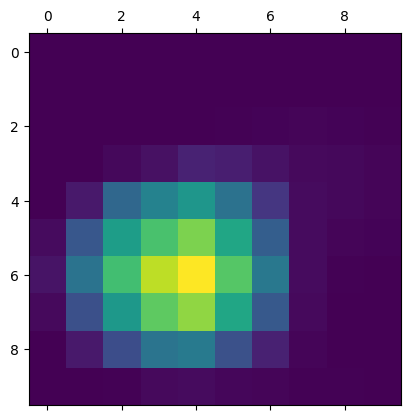

In [26]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model￼
model = model_builder(weights='imagenet')

# Print what the top predicted class is
preds = model.predict(img_array)
print('Predicted:', decode_predictions(preds, top=10)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names)

# Display heatmap
plt.matshow(heatmap)
plt.show()

In [27]:

# Use cv2 to load the original image￼
img = cv2.imread(img_path)

# We resize the heatmap to have the same size as the original image
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# We convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)

# We apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# 0.4 here is a heatmap intensity factor
superimposed_img = heatmap * 0.4 + img

# Save the image to disk

# keras.utils.save_img(f"/drv3/hm3/code/python/tf/keras/Playground/tmp/Visualize_FilterResponses/{layer_name}.jpg",
#                         stitched_filters)  

savePath = "/drv3/hm3/code/python/tf2.18/tf2.18/local/visualizations/VisualizeHeatMaps/"
saveFile = savePath + 'Detect_CatS3.jpg'
cv2.imwrite(saveFile, superimposed_img)

True

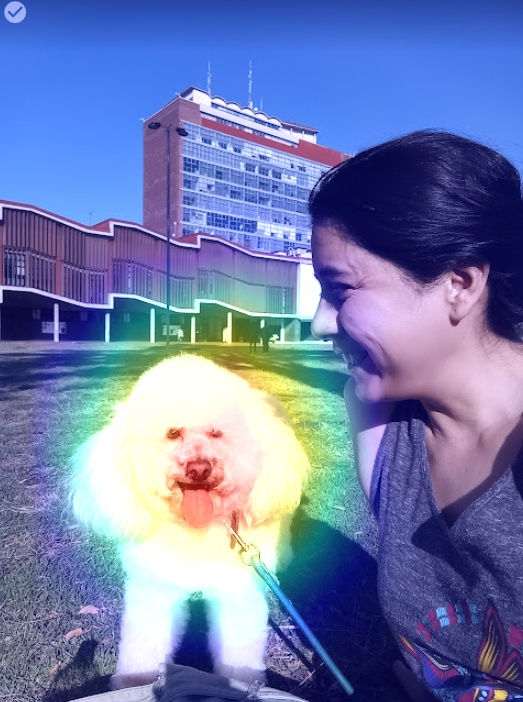

In [28]:

display(Image(saveFile))